In [5]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
'''This script uses the synthetic data from the Groves' MATLAB implementation
of the inertial navigation book (https://github.com/ymjdz/MATLAB-Codes) for IMU sensor
integration'''

"This script uses the synthetic data from the Groves' MATLAB implementation\nof the inertial navigation book (https://github.com/ymjdz/MATLAB-Codes) for IMU sensor\nintegration"

In [7]:
# # Functions

def GetConstants():

    '''This function provides WGS84 ellipsoidal parameters and unit conversions for navigation'''

    return {
        "D2R": math.pi / 180,         # From degrees to radian
        "R2D": 180 / math.pi,         # From radian to degrees
        "omega_ie": 7.2921151467E-5,  # Earth rotation rate [rad/s]
        "R0": 6378137,                # Earth’s equatorial radius (Earth's semi-major axis) [m]
        "Rb": 6356752.3142451793,     # Earth's semi-minor axis [m]
        "mu": 3.986004418e14,         # Earth's Gravitational Constant [m^3/s^2]
        "J2": 1.082627e-3,            # Earth's second Gravitational Constant [m^3/s^2]
        "e1_sqr": 0.0066943799901413156,  # First Eccentricity Squared
        "e2_sqr": 0.0067394967422764341   # Second Eccentricity Squared
    }


def ReadData():

    '''
    This function reads the synthetic position and IMU data
    
    Outputs:
        * output_data - contains the states with noise and the synthetic 
        specific force and angular rate data
        * input_truth_data - contains the ground truth states data
    
    '''
    # # Define paths
    path_root = r'C:\Postdoc\Analysis\Preliminaries\Data\Synthetic_INS_Groves_MATLAB'
    path_simulated = os.path.join(path_root, 'Inertial_Demo_2_Profile.csv')  # This is data with noise, including specific force and angular rate
    path_truth = os.path.join(path_root, 'Profile_2_truth.csv')  # This is the ground truth data

    # Read data
    noisy_state_IMU_data = pd.read_csv(path_simulated, skiprows=[1, 2])
    true_state_data = pd.read_csv(path_truth, skiprows=[1, 2])

    return noisy_state_IMU_data, true_state_data


def euler2dcm(euler):

    '''
    This function constructs the coordinate transformation matrix
    (CTM, also known as DCM (direction cosine matrix)) from body to navigation frame (C_bn)
    
    Inputs:
        euler       Euler angles - phi, theta and psi (roll, pitch, yaw) in radian
           
       '''

    dcm = np.zeros((3, 3))

    phi = euler[0]    # roll
    theta = euler[1]  # pitch
    psi = euler[2]    # yaw (heading)

    cphi = np.cos(phi)
    sphi = np.sin(phi)
    ctheta = np.cos(theta)
    stheta = np.sin(theta)
    cpsi = np.cos(psi)
    spsi = np.sin(psi)

    dcm[0, 0] = ctheta * cpsi
    dcm[0, 1] = -cphi * spsi + sphi * stheta * cpsi
    dcm[0, 2] = sphi * spsi + cphi * stheta * cpsi

    dcm[1, 0] = ctheta * spsi
    dcm[1, 1] = cphi * cpsi + sphi * stheta * spsi
    dcm[1, 2] = -sphi * cpsi + cphi * stheta * spsi

    dcm[2, 0] = -stheta
    dcm[2, 1] = sphi * ctheta
    dcm[2, 2] = cphi * ctheta

    return dcm


def SkewSymmetric(a):

    '''
    This function converts a vector x into a skew symmetric matrix
    which multiplication by a vector y is equivalent to performing
    a cross product between vectors x and y

     Inputs:
           a       3-element vector
     Outputs:
           A       3x3 matrix
    '''

    A = np.array([
        [0, -a[2], a[1]],
        [a[2], 0, -a[0]],
        [-a[1], a[0], 0]
    ])

    return A


def RadiiOfCurvature(L_b):

    '''
    This function calculates the transverse and the meridian radii of curavture 
    given the a specific lattitude

    Inputs:
           L_b    geodetic latitude [rad]
     Outputs:
           R_E    transverse radius of curvature [m]
           R_M    meridian radius of curvature [m]
    
    
    '''

    # Parameters
    R_0 = 6378137 # WGS84 Equatorial radius [m]
    e = 0.0818191908425; # WGS84 eccentricity

    # Preparataions
    temp = 1 - (e * np.sin(L_b))**2

    # Calculate transverse radius of curvature (using Eq. 2.105)
    R_E = R_0 / np.sqrt(temp);
    
    # Calculate meridian radius of curvature (using Eq. 2.105)    
    R_N = R_0 * (1 - e**2) / temp**1.5;    

    return  R_E, R_N

def Gravity_NED(L_b, h_b):

    '''
    This function calculates acceleration due to gravity resolved about 
    north, east, and down

    Inputs:
           lat    geodetic latitude [rad]
           h_b    height [m]
     Outputs:
           g       Acceleration due to gravity [m/s^2]
    '''

    # Parameters
    R_0 = 6378137  # %WGS84 Equatorial radius in meters
    R_P = 6356752.31425  # WGS84 Polar radius in meters
    e = 0.0818191908425  # WGS84 eccentricity
    f = 1 / 298.257223563  # WGS84 flattening
    mu = 3.986004418E14  # WGS84 Earth gravitational constant (m^3 s^-2)
    omega_ie = 7.292115E-5  # Earth rotation rate (rad/s)
    
    # Calculate surface gravity using the Somigliana model (Eq. 2.134)
    sinsqL = np.sin(L_b)**2
    g_0 = 9.7803253359 * (1 + 0.001931853 * sinsqL) / np.sqrt(1 - e**2 * sinsqL)

    # Preallocate g
    g = np.zeros([3,1])

    
    # Calculate north gravity using (2.140)
    g_N = -8.08E-9 * h_b * np.sin(2 * L_b)
    
    # East gravity is zero
    g_E = 0
    
    # Calculate down gravity using (2.139)
    g_D = g_0 * (1 - 
                  (2 / R_0) * (1 + f * (1 - 2 * sinsqL) + (omega_ie**2 * R_0**2 * R_P / mu)) * h_b + 
                  (3 * h_b**2 / R_0**2))
                    
    return np.array([g_N, g_E, g_D])


def CTM_to_Euler(C):

    """
    This function onverts a coordinate transformation matrix to the
    corresponding set of Euler angles

    Inputs:
        C       coordinate transformation matrix describing transformation from
                beta to alpha
 
  Outputs:
        eul     Euler angles describing rotation from beta to alpha in the 
                order roll, pitch, yaw(rad)
    """

    # Preallocate output
    eul = np.zeros(3)
    
    # Calculate Euler angles using (2.23)
    eul[0] = np.arctan2(C[1,2],C[2,2]);  # roll  [rad]
    eul[1] = - np.arcsin(C[0,2]);        # pitch [rad]
    eul[2] = np.arctan2(C[0,1],C[0,0]);  # yaw   [rad]
    
    return eul


In [8]:
# Read data
imu, truth = ReadData()

imu.head()

,time,lat,lon,height,vel_N,vel_E,vel_D,phi,theta,psi,f_X,f_Y,f_Z,omega_X,omega_Y,omega_Z
0,0.01,50.425036,-3.595804,46.999000,0.049978,9.949228,0.099979,0.007998,0.009996,90.009998,-0.07530,-0.00025,-9.81210,-0.000006,-0.000053,-0.000061
1,0.02,50.425036,-3.595802,46.998000,0.049974,9.949603,0.099969,0.008000,0.009993,90.010001,0.03950,-0.00220,-9.81100,0.000003,-0.000053,-0.000054
2,0.03,50.425036,-3.595801,46.997001,0.049958,9.950789,0.099958,0.008001,0.009987,90.009997,0.12045,-0.00085,-9.81110,0.000001,-0.000059,-0.000065
3,0.04,50.425036,-3.595800,46.996001,0.049918,9.951678,0.099946,0.008002,0.009992,90.010002,0.09090,0.00140,-9.81115,0.000003,-0.000038,-0.000048
4,0.05,50.425036,-3.595798,46.995002,0.049940,9.951620,0.099932,0.008007,0.009988,90.010001,-0.00390,-0.00465,-9.81140,0.000009,-0.000056,-0.000060


In [5]:
# Get Constants
Const = GetConstants()

# Read data
imu, truth = ReadData()

# Get number of epochs
no_epochs = imu.shape[0]

# Perform script initialization
# Initialize estimated navigation solution
old_time = imu['time'][0]  # [sec]
old_est_L_b = imu['lat'][0] * Const['D2R']  # [rad]
old_est_lambda_b = imu['lon'][0] * Const['D2R']  # [rad]
old_est_h_b = imu['height'][0]  # [m]
old_est_v_eb_n = imu.iloc[0, 4:7].to_numpy()  # [m/s]
old_est_eul_nb = imu.iloc[0, 7:10].to_numpy() * Const['D2R']  # [rad]
old_est_C_b_n = euler2dcm(old_est_eul_nb)


# # Save navigation solution in a dedicated array
# Preallocation
nav_solution = np.zeros((no_epochs,10))

# nav_solution is the dataframe where states obtained by integrating IMU data will be saved
nav_solution[0,:] = imu.iloc[0, :10].to_numpy()


# ---------------------
# Main loop - Start IMU integration
# ---------------------
for epoch in range(1,no_epochs):

    # Unpack current measured data
    new_time = imu['time'][epoch]  # time stamp [sec]
    f_ib_b = imu.iloc[epoch, 10:13].to_numpy()   # Specific force [m/s^2]
    omega_ib_b = imu.iloc[epoch, 13:16].to_numpy()  # angular rate [rad/s]
    
    # Get the time interval between the previous and current measurement
    dt = new_time - old_time

    
    # # Update estimated navigation solution (integrate IMU data)
    # # Beginning of the Nav_equations_NED function from Groves' MATLAB script
    # PRELIMINARIES
    # Calculate attitude increment, magnitude, and skew-symmetric matrix
    alpha_ib_b = omega_ib_b * dt
    mag_alpha = np.linalg.norm(alpha_ib_b)
    Alpha_ib_b = SkewSymmetric(alpha_ib_b)

    
    # # Calculate the engular rate of the ECEF frame w.r.t the ECI frame,
    # resolved about NED (omega_en_n) (Eq. 2.123)
    old_omega_ie_n = Const['omega_ie'] * np.array([np.cos(old_est_L_b),0,-np.sin(old_est_L_b)])

    
    # # Calculate the angular rate of the NED frame w.r.t the ECEF frame,
    # resolved about NED (Eq. 5.44)

    # Get radii of curevture
    old_R_E, old_R_M = RadiiOfCurvature(old_est_L_b)

    # determine omega_en_n
    old_omega_en_n = np.array([
        old_est_v_eb_n[1]/(old_R_E + old_est_h_b),
        -old_est_v_eb_n[0]/(old_R_M + old_est_h_b),
        -old_est_v_eb_n[1]*np.tan(old_est_L_b)/(old_R_E + old_est_h_b)
    ])

    
    # # Specific force frame transformation
    # Calculate the average body-to-NED-frame coordinate transformation
    # matrix over the update interval using Eq. 5.84 and  Eq. 5.86
    if mag_alpha > 1e-8:
        # Series expansion components
        term1 = (1 - np.cos(mag_alpha)) / (mag_alpha**2) * Alpha_ib_b
        term2 = (1 - (np.sin(mag_alpha) / mag_alpha)) / (mag_alpha**2) * (Alpha_ib_b @ Alpha_ib_b)
        
        # Earth/Transport rate correction part
        earth_rate_term = 0.5 * SkewSymmetric(old_omega_ie_n + old_omega_en_n) @ old_est_C_b_n
        
        # Combined update (Note the @ for matrix multiplication)
        ave_C_b_n = old_est_C_b_n @ (np.eye(3) + term1 + term2) - earth_rate_term 
    else:
        # Small angle approximation
        earth_rate_term = 0.5 * SkewSymmetric(old_omega_ie_n + old_omega_en_n) @ old_est_C_b_n
        ave_C_b_n = old_est_C_b_n - earth_rate_term

    # Transform specific force to NED-frame resolving axes (Eq. 5.86)
    f_ib_n = ave_C_b_n @ f_ib_b

    
    # # Update velocity (using Eq. 5.54)
    new_est_v_eb_n = old_est_v_eb_n + dt * (f_ib_n + Gravity_NED(old_est_L_b, old_est_h_b) - 
                                           SkewSymmetric(old_omega_en_n + 2 * old_omega_ie_n) @ old_est_v_eb_n)

    
    # # Update curvilinear position
    # Update height (using Eq. 5.56)
    new_est_h_b = old_est_h_b + 0.5 * dt * (old_est_v_eb_n[2] + new_est_v_eb_n[2])

    # Update latitude (using Eq. 5.56)
    new_est_L_b = old_est_L_b + 0.5 * dt * (old_est_v_eb_n[0]/(old_R_M + old_est_h_b) + 
                                            new_est_v_eb_n[0]/(old_R_M + new_est_h_b))


    # Recalculate meridian and transverse radii of curvature
    new_R_E, new_R_M = RadiiOfCurvature(new_est_L_b);

    # Update longitude (using Eq. 5.56)
    new_est_lambda_b = (old_est_lambda_b + 
                   0.5 * dt * (old_est_v_eb_n[1]/((old_R_E + old_est_h_b)*np.cos(old_est_L_b)) + 
                               new_est_v_eb_n[1]/((new_R_E + new_est_h_b)*np.cos(new_est_L_b))))


    # # Update attitude
    # Determine the angular rate of the NED frame w.r.t the ECEF frame, 
    # resolved around NED (calculate transport rate using Eq. 5.44)
    new_omega_en_n = np.array([
        new_est_v_eb_n[1]/(new_R_E + new_est_h_b),
        -new_est_v_eb_n[0]/(new_R_M + new_est_h_b),
        -new_est_v_eb_n[1]*np.tan(new_est_L_b)/(new_R_E + new_est_h_b)
    ])

    # Obtain coordinate transformation matrix from the new attitude w.r.t. an
    # inertial frame to the old using Rodrigues' formula, (Eq. 5.73)
    if mag_alpha > 1.E-8:
        C_new_old = (np.eye(3) + 
                     (np.sin(mag_alpha) / mag_alpha) * Alpha_ib_b + 
                     ((1 - np.cos(mag_alpha)) / mag_alpha**2) * (Alpha_ib_b @ Alpha_ib_b))
    else:
        # Small angle approximation
        C_new_old = np.eye(3) + Alpha_ib_b

    # Update attitude (using Eq. 5.77)
    Omega_term = SkewSymmetric(old_omega_ie_n + 0.5*old_omega_en_n + 0.5*new_omega_en_n)
    new_est_C_b_n = ((np.eye(3) - Omega_term * dt) @ old_est_C_b_n @ C_new_old)

    # Get attitude in Euler angles
    new_est_eul_nb = CTM_to_Euler(new_est_C_b_n)

    # Reset old values
    old_time = new_time;
    old_est_L_b = new_est_L_b  # [rad]
    old_est_lambda_b = new_est_lambda_b  # [rad]
    old_est_h_b = new_est_h_b  # [m]
    old_est_v_eb_n = new_est_v_eb_n  # [m/s]
    old_est_eul_nb = new_est_eul_nb # [rad]
    old_est_C_b_n = new_est_C_b_n

    # Save navigation solution in a dedicated array
    nav_solution[epoch,0] = new_time  # [sec]
    nav_solution[epoch,1] = new_est_L_b  * Const['R2D']  # [deg]
    nav_solution[epoch,2] = new_est_lambda_b   * Const['R2D']  # [deg]
    nav_solution[epoch,3] = new_est_h_b  # [m]
    nav_solution[epoch,4:7] = new_est_v_eb_n  # [m/s]
    nav_solution[epoch,7:10] = new_est_eul_nb * Const['R2D']  # [deg]

# Convert everything to a DataFrame once at the end
nav_solution = pd.DataFrame(nav_solution, columns=imu.columns[:10])


NameError: name 'nav_solution' is not defined

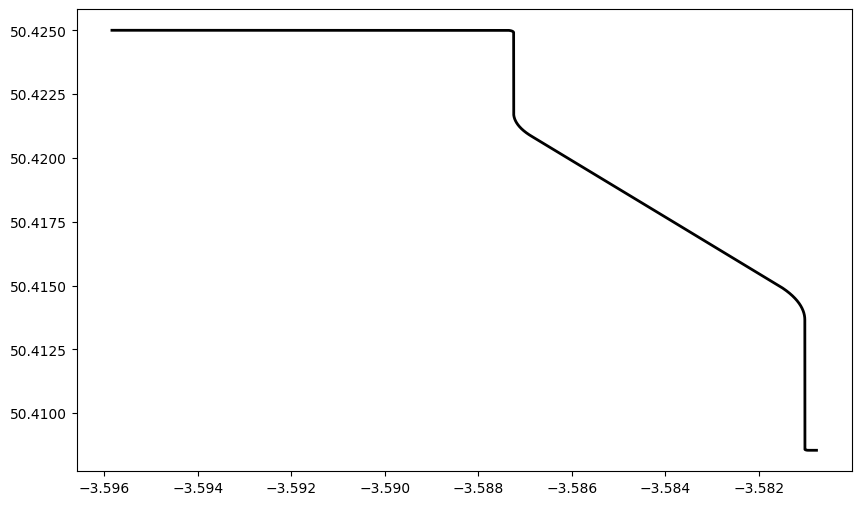

In [9]:
plt.figure(figsize=(10,6))

# Plot trajectories
plt.plot(truth['lon'], truth['lat'], 'k-', linewidth=2, label='Ground Truth')
plt.plot(nav_solution['lon'], nav_solution['lat'], 'r--', linewidth=1.5, label='INS integration')

# Highlight start and end points
plt.plot(truth['lon'].iloc[0], truth['lat'].iloc[0], 'go', markersize='8', label='Start')
plt.plot(truth['lon'].iloc[-1], truth['lat'].iloc[-1], 'rx', markersize='8', label='End')

# Formatting
plt.title('Navigation solution: Integrated IMU vs. Ground Truth', fontsize=14)
plt.xlabel('Longitude [deg]', fontsize=12)
plt.xlabel('Latitude [deg]', fontsize=12)
plt.grid(True, linestyle=':', alpha = 0.7)
plt.legend(loc='best')

# Ensure equal aspect ratio
plt.axis('equal')

plt.tight_layout()
plt.show()



In [166]:
print(f"v: {old_est_v_eb_n.shape}, f: {f_ib_n.shape}, skew: {SkewSymmetric(old_omega_en_n + 2 * omega_ie_n).shape}, g: {Gravity_NED(old_est_L_b, old_est_h_b).shape}")

v: (3,), f: (3,), skew: (3, 3), g: (1, 3)


In [165]:
print(type(old_est_v_eb_n), type(f_ib_n), type(SkewSymmetric(old_omega_en_n + 2 * omega_ie_n)), type(Gravity_NED(old_est_L_b, old_est_h_b)))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [1]:
nav_solution['lat']*Const['D2R']

NameError: name 'nav_solution' is not defined